In [5]:
import getpass
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when running from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
    from LIFE_retrieval.target import Target
    from LIFE_retrieval.retrieval import Retrieval
    from LIFE_retrieval.parameters import Parameters
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from retrieval import Retrieval
    from parameters import Parameters

target_object = 'Sorg1'
Nlive=200 # number of live points (integer)
evtol=0.5 # evidence tolerance (float)
bayes=False

def init_retrieval(obj,Nlive,evtol,PT_type='PTknot',chem='const'):

    output=f'{obj}_N{Nlive}_e{evtol}' # output folder name
    obj = Target(obj)

    constant_params={'rv':0,
                     'log_opa_base_gray': -10,  
                    'log_P_base_gray': 3, # pressure of gray cloud deck
                    'fsed_gray': 20} # add if needed
    
    free_params = {#'rv': ([0,20],r'$v_{\rm rad}$'),
                'log_g':([1,3],r'log $g$')}
    
    if PT_type=='PTknot':
        pt_params={'T0' : ([100,1000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,1000], r'$T_1$'),
                'T2' : ([0,1000], r'$T_2$'),
                'T3' : ([0,1000], r'$T_3$'),
                'T4' : ([0,1000], r'$T_4$'),
                'T5' : ([0,1000], r'$T_5$'),
                'T6' : ([0,1000], r'$T_6$')} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([-0.4,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([-0.4,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([-0.4,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([-0.4,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([-0.4,0.4], r'$\nabla T_4$'), 
                'T0': ([100,1000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)
        
    # free chemistry, define VMRs
    chemistry={'log_H2O':([-12,-1],r'log H$_2$O'),
                'log_CO':([-12,-1],r'log CO'),
                'log_CO2':([-12,-1],r'log CO$_2$'),
                'log_CH4':([-12,-1],r'log CH$_4$'),
                'log_NH3':([-12,-1],r'log NH$_3$'),
                'log_HCN':([-12,-1],r'log HCN'),
                'log_H2S':([-12,-1],r'log H$_2$S'),
                'log_C2H2':([-12,-1],r'log C$_2$H$_2$'),
                'log_C2H4':([-12,-1],r'log C$_2$H$_4$'),
                'log_C2H6':([-12,-1],r'log C$_2$H$_6$'),
                'log_CH3Cl':([-12,-1],r'log CH$_3$Cl'),
                'log_SO2':([-12,-1],r'log SO$_2$'),
                'log_OCS':([-12,-1],r'log OCS'),
                'log_CS2':([-12,-1],r'log CS$_2$'),
                'log_DMS':([-12,-1],r'log DMS')}
       
    if chem=='var':
        varchem={}
        for key in chemistry.keys():
            varchem[f'{key}_0']=chemistry[key]
            varchem[f'{key}_1']=chemistry[key]
            varchem[f'{key}_2']=chemistry[key]
        chemistry=varchem

    #cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                #'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                #'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
    
    #free_params.update(cloud_props)
    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)
    retrieval=Retrieval(target=obj,parameters=parameters,output_name=output,
                        N_live_points=Nlive,evidence_tolerance=evtol,PT_type=PT_type,chem=chem)

    return retrieval

retrieval=init_retrieval(target_object,Nlive,evtol,PT_type='PTknot',chem='var')
#retrieval.PMN_lnL()
#retrieval.run_retrieval(bayes=bayes)
#retrieval.evaluate(makefigs=False)


0.039395603731360404 0.000802555885335784 1.7408173065465071
0.0002402207466346105 0.038827932433359004 1.6614753136275644
0.024514007179401047 0.02095512207818483 1.7236862735951728


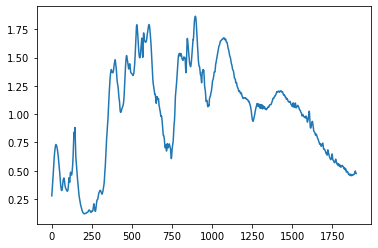

In [6]:
from pRT_model import pRT_spectrum
import matplotlib.pyplot as plt
model_object=pRT_spectrum(retrieval)
model_flux=model_object.make_spectrum()
plt.plot(model_flux)

In [3]:
layers = np.empty(50)
for l in range(50):
    mf=0
    for key in model_object.mass_fractions.keys():
        if key!='MMW':
            #print(key,model_object.mass_fractions[key][l])
            mf+=model_object.mass_fractions[key][l]
    layers[l]=mf
layers

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
model_object.CO

16.754565678940192

In [12]:
model_object.mass_fractions

{'CO_12_HITEMP': array([4.49206805e-08, 4.08229964e-08, 3.70991048e-08, 3.37149083e-08,
        3.06394196e-08, 2.78444784e-08, 2.53044929e-08, 2.29962060e-08,
        2.08984820e-08, 1.89921134e-08, 1.72596445e-08, 1.56852122e-08,
        1.42544003e-08, 1.29541077e-08, 1.17724283e-08, 1.06985422e-08,
        9.72261655e-09, 8.83571522e-09, 8.02971742e-09, 7.29724308e-09,
        6.63158538e-09, 6.02664927e-09, 5.47689569e-09, 4.97729087e-09,
        4.52326022e-09, 4.45758764e-09, 4.76362948e-09, 5.09068304e-09,
        5.44019091e-09, 5.81369473e-09, 6.21284198e-09, 6.63939322e-09,
        7.09522993e-09, 7.58236274e-09, 8.10294033e-09, 8.65925888e-09,
        9.25377226e-09, 9.88910277e-09, 1.05680528e-08, 1.12936170e-08,
        1.20689959e-08, 1.28976095e-08, 1.37831127e-08, 1.47294113e-08,
        1.57406794e-08, 1.68213775e-08, 1.79762724e-08, 1.92104582e-08,
        2.05293787e-08, 2.19388516e-08]),
 'H2O_Exomol': array([5.71929601e-02, 2.70785791e-02, 1.28206242e-02, 6.070052

In [ ]:
np.ones()


 ------ Sorg1 - Nlive: 200 - ev: 0.5 ------- 


 ----------------- Starting main retrieval. ----------------- 

Invalid flux inf
{'CO_12_HITEMP': array([2.50271265e-01, 1.65914941e-01, 1.09991723e-01, 7.29179604e-02,
       4.83402643e-02, 3.20467157e-02, 2.12450636e-02, 1.40842117e-02,
       9.33699339e-03, 6.18987044e-03, 4.10351539e-03, 2.72038627e-03,
       1.80345405e-03, 1.19558261e-03, 7.92600054e-04, 5.25446623e-04,
       3.48339812e-04, 2.30928546e-04, 1.53091870e-04, 1.01490791e-04,
       6.72823487e-05, 4.46041894e-05, 2.95699206e-05, 1.96030960e-05,
       1.29956850e-05, 8.85213991e-06, 6.19543710e-06, 4.33606351e-06,
       3.03472482e-06, 2.12394369e-06, 1.48650605e-06, 1.04037609e-06,
       7.28138586e-07, 5.09609750e-07, 3.56665753e-07, 2.49623285e-07,
       1.74706384e-07, 1.22273532e-07, 8.55768192e-08, 5.98935179e-08,
       4.19182849e-08, 2.93377759e-08, 2.05329273e-08, 1.43705885e-08,
       1.00576897e-08, 7.03917751e-09, 4.92658068e-09, 3.44801607e-09,
 

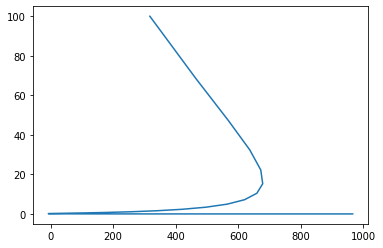

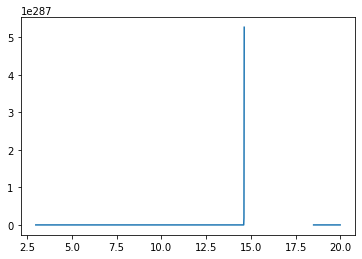

Exception ignored on calling ctypes callback function: <function run.<locals>.loglike at 0x7f2cd6e4dc10>
Traceback (most recent call last):
  File "/home/natalie/.local/lib/python3.8/site-packages/pymultinest/run.py", line 228, in loglike
    return LogLikelihood(cube, ndim, nparams)
  File "/home/natalie/Desktop/files/uni/PhD/LIFE/LIFE_retrieval/LIFE_retrieval/retrieval.py", line 105, in PMN_lnL
    self.model_flux=self.model_object.make_spectrum()
  File "/home/natalie/Desktop/files/uni/PhD/LIFE/LIFE_retrieval/LIFE_retrieval/pRT_model.py", line 220, in make_spectrum
    atmosphere.calc_flux(self.temperature,
  File "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py", line 1347, in calc_flux
    self.interpolate_species_opa(temp)
  File "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py", line 550, in interpolate_species_opa
    self.line_struc_kappas[:, :, i_spec, :] = fi.interpol_opa_ck(
KeyboardInterrupt: 


Invalid flux inf
{'CO_12_HITEMP': array([7.77759982e-11, 8.16429364e-11, 8.57021346e-11, 8.99631518e-11,
       9.44360220e-11, 9.91312786e-11, 1.04059978e-10, 1.09233727e-10,
       1.14664710e-10, 1.20365715e-10, 1.26350167e-10, 1.32632161e-10,
       1.39226488e-10, 1.46148677e-10, 1.53415031e-10, 1.61042660e-10,
       1.69049526e-10, 1.77454485e-10, 1.86277330e-10, 1.95538836e-10,
       2.05260815e-10, 2.15466160e-10, 2.26178904e-10, 2.37424273e-10,
       2.49228750e-10, 3.54319247e-10, 6.82205050e-10, 1.31351524e-09,
       2.52903769e-09, 4.86940040e-09, 9.37552666e-09, 1.80516065e-08,
       3.47565007e-08, 6.69200460e-08, 1.28847625e-07, 2.48082770e-07,
       4.77657705e-07, 9.19680490e-07, 1.77074963e-06, 3.40939520e-06,
       6.56443770e-06, 1.26391456e-05, 2.43353671e-05, 4.68552315e-05,
       9.02149004e-05, 1.73699457e-04, 3.34440332e-04, 6.43930256e-04,
       1.23982108e-03, 2.38714722e-03]), 'H2O_Exomol': array([8.81878294e-05, 4.54907271e-05, 2.34658940e-05, 1.21

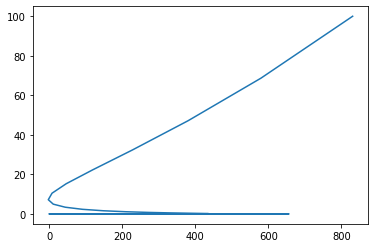

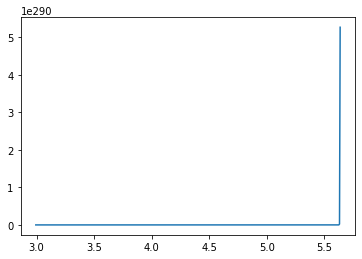

In [ ]:
retrieval.run_retrieval()

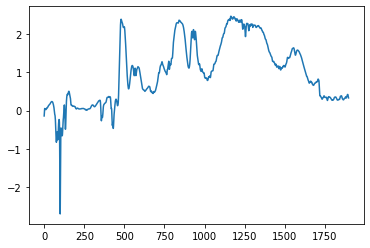

In [4]:
from pRT_model import pRT_spectrum
import matplotlib.pyplot as plt
model_object=pRT_spectrum(retrieval)
model_flux=model_object.make_spectrum()
plt.plot(model_flux)

array([2.61810656, 2.70035824, 2.78519398, 2.87269496, 2.96294491,
       3.0560302 , 3.1520399 , 3.25106588, 3.35320291, 3.45854873,
       3.56720415, 3.67927313, 3.79486292, 3.91408414, 4.03705087,
       4.16388079, 4.29469525, 4.42961944, 4.56878247, 4.71231751,
       4.86036192, 5.01305736, 5.17054996, 5.33299042, 5.50053418,
       5.5140467 , 5.37238985, 5.23437219, 5.09990023, 4.96888287,
       4.84123138, 4.71685927, 4.59568231, 4.47761841, 4.36258759,
       4.25051193, 4.14131551, 4.03492437, 3.93126644, 3.8302715 ,
       3.73187113, 3.63599869, 3.54258923, 3.45157948, 3.36290778,
       3.27651408, 3.19233984, 3.11032806, 3.03042317, 2.95257105])

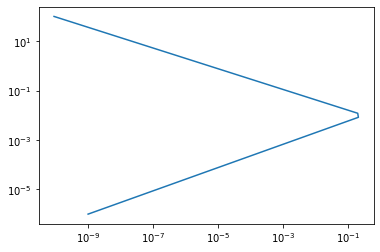

In [5]:
plt.plot(model_object.mass_fractions['DMS'],model_object.pressure)
plt.yscale('log')
plt.xscale('log')
model_object.mass_fractions['MMW']

In [13]:
model_object.mass_fractions

{'CO_12_HITEMP': array([3.95674282e-11, 3.46815027e-06, 6.93626098e-06, 1.04043717e-05,
        1.38724824e-05, 1.73405931e-05, 2.08087038e-05, 2.42768145e-05,
        2.77449252e-05, 3.12130359e-05, 3.46811466e-05, 3.81492573e-05,
        4.16173680e-05, 4.50854787e-05, 4.85535894e-05, 5.20217001e-05,
        5.54898108e-05, 5.89579215e-05, 6.24260322e-05, 6.58941429e-05,
        6.93622536e-05, 7.28303643e-05, 7.62984751e-05, 7.97665858e-05,
        8.32346965e-05, 8.32387533e-05, 7.97787562e-05, 7.63187592e-05,
        7.28587621e-05, 6.93987650e-05, 6.59387680e-05, 6.24787709e-05,
        5.90187739e-05, 5.55587768e-05, 5.20987798e-05, 4.86387827e-05,
        4.51787856e-05, 4.17187886e-05, 3.82587915e-05, 3.47987945e-05,
        3.13387974e-05, 2.78788003e-05, 2.44188033e-05, 2.09588062e-05,
        1.74988092e-05, 1.40388121e-05, 1.05788150e-05, 7.11881799e-06,
        3.65882093e-06, 1.98823869e-07]),
 'H2O_Exomol': array([1.53409339e-02, 1.47147733e-02, 1.40886127e-02, 1.346245

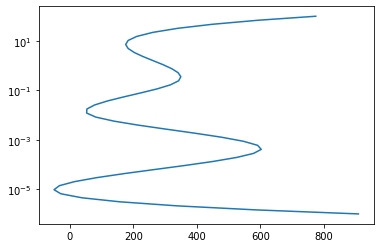

In [6]:
plt.plot(model_object.temperature,model_object.pressure)
plt.yscale('log')

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# weird format???
filename='psg_rad_Sorg1X.txt'
file1=np.genfromtxt(filename,skip_header=13,skip_footer=1488,delimiter='  ')
wl1=file1[:,0]
fl1=file1[:,1]
flerr1=np.ones_like(fl1)*1e-5
file2=np.genfromtxt(filename,skip_header=424,delimiter='  ')
wl2=file2[:,0]
fl2=file2[:,1]
flerr2=file2[:,2]
wl=np.append(wl1,wl2)
fl=np.append(fl1,fl2)
fl/=np.median(fl)
flerr=np.append(flerr1,flerr2)


/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



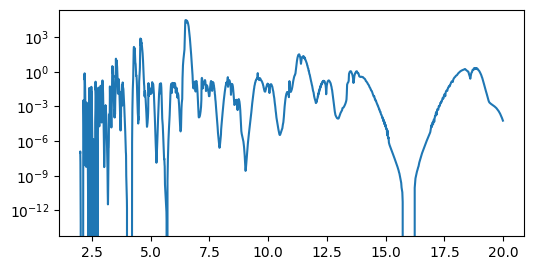

In [1]:
import os
import numpy as np
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans
import matplotlib.pyplot as plt

wlen_range=np.array([2,20]) # in microns for pRT
atmosphere_object = Radtrans(line_species=['CS2'],
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='c-k')

T = np.array([300]).reshape(1)
wave_cm, opas = atmosphere_object.get_opa(T)
wave_um = wave_cm*1e4 # microns

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=100)
spec,=plt.plot(wave_um,opas['CS2'])
plt.yscale('log')


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



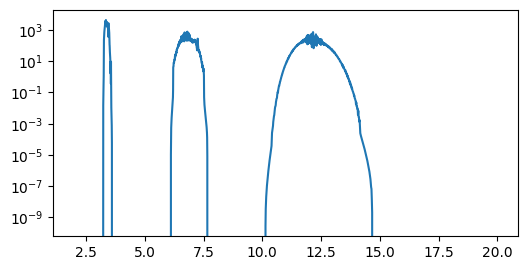

In [13]:
import os
import numpy as np
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans
import matplotlib.pyplot as plt

wlen_range=np.array([2,20]) # in microns for pRT
atmosphere_object = Radtrans(line_species=['C2H6'],
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='c-k')

T = np.array([300]).reshape(1)
wave_cm, opas = atmosphere_object.get_opa(T)
wave_um = wave_cm*1e4 # microns

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=100)
spec,=plt.plot(wave_um,opas['C2H6'])
plt.yscale('log')


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



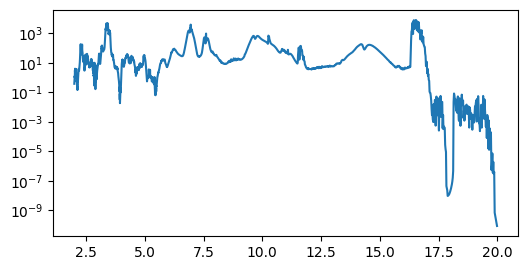

In [ ]:
import os
import numpy as np
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans
import matplotlib.pyplot as plt

wlen_range=np.array([2,20]) # in microns for pRT
atmosphere_object = Radtrans(line_species=['DMS'],
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='c-k')

T = np.array([300]).reshape(1)
wave_cm, opas = atmosphere_object.get_opa(T)
wave_um = wave_cm*1e4 # microns

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=100)
spec,=plt.plot(wave_um,opas['DMS'])
plt.yscale('log')
